# Nonstationary Multi-Armed Bandits

The first part of the homework deals with the Multi Armed Bandit Problem.
In particular, the 10-armed testbed environment is exploited in order to understand what happens when dynamics are introduced in the arm rewards.
In order to complete the following exercise you will have to **modify** the 10-armed testbed environment in such a way that the mean values $q(a)$ of all the arms **start out equal** and then take **independent random walks**. This means that we will have:

$$ q_0(a) = 0, \qquad \forall a \in \mathcal{A}$$

$$q_t(a) = q_{t-1}(a) + w_{t-1}, \qquad \forall a \in \mathcal{A}, \qquad \textrm{where} \quad w_t \sim \mathcal{N}(0, \sigma^2)$$

Assume $\sigma = 0.1$.

Compare the performance of two different instances of the **Epsilon-Greedy algorithm**, one using **sample averages**, and the other using a **constant step size** $\alpha = 0.1$.
Plot the **average reward**, the **cumulative average reward**, and the **average percentage of optimal actions**: use $\epsilon=0.1$ and average over $500 \ \texttt{runs}$ for $5000 \ \texttt{steps}$.

##  IMPORTANT: Make sure that **before** the cell saying 'HERE ENDS THE FIRST EXERCISE' you have a variable called 'rewards' which is a numpy nd-array containing the average (over different runs) rewards of the two algorithms! To check this, you can run the assert statement in the cell: if it does not raise an error, you should be fine.

In [1]:
# Install packages in ipython
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
## Credits and imports

#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import seaborn as sns
from scipy.stats import poisson
from typing import List

For your convenience, the code discussed in the first "tutorial lesson" is reported below. Feel free to modify the code as you wish in order to achieve the required result.


In [3]:
class PolicyUpdate:
    def update(self, policy, action, reward):
        pass
    def reset(self):
        pass


class SampleAverageUpdate(PolicyUpdate):
    def __init__(self, n_action: int):
        self.n = n_action
        self.action_count = np.zeros(n_action)
    def update(self, policy: "Policy", action: int, reward: float):
        self.action_count[action] += 1
        policy.q_estimation[action] += (reward - policy.q_estimation[action]) / self.action_count[action]
    def reset(self):
        self.action_count = np.zeros(self.n)


class GradientUpdate(PolicyUpdate):
    def __init__(self, n_action: int, gradient_baseline: bool, step_size: float):
        self.n = n_action
        self.gradient_baseline = gradient_baseline
        self.step_size = step_size
        self.average_reward = 0
        self.time = 0

    def update(self, policy: "Policy", action: int, reward: float):
        self.time += 1
        self.average_reward += (reward - self.average_reward) / self.time
        one_hot = np.zeros(self.n)
        one_hot[action] = 1
        if self.gradient_baseline:
            baseline = self.average_reward
        else:
            baseline = 0
        exp_est = np.exp(policy.q_estimation) # not really Q, this would be H in the formula
        action_prob = exp_est / np.sum(exp_est)
        policy.q_estimation += self.step_size * (reward - baseline) * (one_hot - action_prob)
    def reset(self):
        self.average_reward = 0
        self.time = 0

class ConstantUpdate(PolicyUpdate):
    def __init__(self, n_action: int, step_size: float):
        self.n = n_action
        self.step_size = step_size
    def update(self, policy: "Policy", action: int, reward: float):
        policy.q_estimation[action] += self.step_size * (reward - policy.q_estimation[action])
    def reset(self):
        pass




class Policy:
    def __init__(self, policy_update: PolicyUpdate, n_actions: int, initial: float):
        self.policy_update = policy_update
        self.n = n_actions
        self.initial = initial
        self.q_estimation = np.zeros(self.n) + self.initial
    def act(self):
        raise NotImplementedError(f"You forgot to implement 'act' in class {self.__class__.__name__}")
    def step(self, action: int, reward: float):
        raise NotImplementedError(f"You forgot to implement 'step' in class {self.__class__.__name__}")
    def reset(self):
        self.q_estimation = np.zeros(self.n) + self.initial
        self.policy_update.reset()

class EpsilonGreedyPolicy(Policy):
    def __init__(self, policy_update: PolicyUpdate, n_actions: int, epsilon: float, initial: float=0.):
        super().__init__(policy_update, n_actions, initial)
        self.epsilon = epsilon
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n)
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    def step(self, action: int, reward: float):
        self.policy_update.update(self, action, reward)

class UCBPolicy(Policy):
    def __init__(self, policy_update: PolicyUpdate, n_actions: int, UCB_param: float, initial: float=0):
        super().__init__(policy_update, n_actions, initial)
        self.UCB_param = UCB_param
        self.time = 0
        self.action_count = np.zeros(self.n)
    def act(self):
        UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
        q_best = np.max(UCB_estimation)
        return np.random.choice(np.where(UCB_estimation == q_best)[0])
    def step(self, action: int, reward: float):
        self.time += 1
        self.action_count[action] += 1
        self.policy_update.update(self, action, reward)
    def reset(self):
        super().reset()
        self.action_count = np.zeros(self.n)
        self.time = 0

class GradientPolicy(Policy):
    def __init__(self, policy_update: PolicyUpdate, n_actions: int, initial: float=0):
        super().__init__(policy_update, n_actions, initial)
        self.q_estimation = np.zeros(self.n)
    def act(self):
        exp_est = np.exp(self.q_estimation)
        action_prob = exp_est / np.sum(exp_est)
        return np.random.choice(np.arange(0, self.n), p=action_prob)
    def step(self, action: int, reward: float):
        self.policy_update.update(self, action, reward)

In [4]:
class Environment:
    def __init__(self, n_actions, true_reward = 0.):
        self.n = n_actions
        self.true_reward = true_reward
        self.q_true = np.random.randn(self.n) + self.true_reward
    def reset(self):
        self.q_true = np.random.randn(self.n) + self.true_reward
    def reward(self, action: int):
        self.q_true = self.q_true + np.random.normal(0, .1, size=self.n)
        return np.random.randn() + self.q_true[action]
    @property
    def best_action(self):
        return np.argmax(self.q_true)

100%|██████████| 500/500 [00:25<00:00, 19.46it/s]


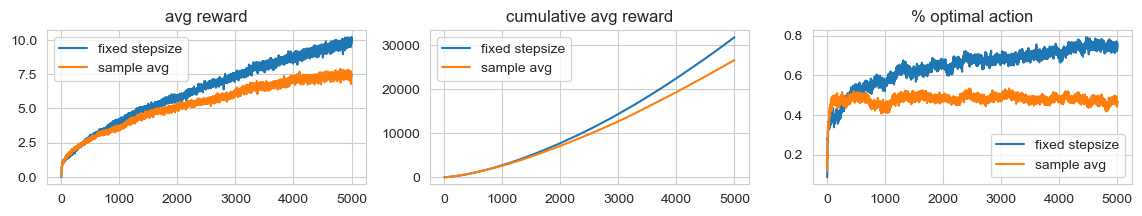

In [5]:
K=10
def simulate(runs, time, policies: List[Policy], environment: Environment):
    rewards = np.zeros((len(policies), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, policy in enumerate(policies):
        for r in trange(runs):
            policy.reset()
            environment.reset()
            for t in range(time):
                action = policy.act()
                reward = environment.reward(action)
                policy.step(action, reward)
                rewards[i, r, t] = reward
                if action == environment.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

# Recall you have to modify the environment above!

bandits = [
    EpsilonGreedyPolicy(epsilon=0.1, policy_update=ConstantUpdate(K, 0.1), n_actions=K),
    EpsilonGreedyPolicy(epsilon=0.1, policy_update=SampleAverageUpdate(K), n_actions=K),
]
environment = Environment(K)
mean_best_action_counts, rewards = simulate(500, 5000, bandits, environment)

# Code for the figures
# Plot the average reward, the cumulative average reward, and the average percentage of optimal actions
fig, ax = plt.subplots(1,3, figsize=(14,2))
ax[0].set_title("avg reward")
ax[0].plot(rewards.T)
ax[0].legend(["fixed stepsize", "sample avg"])
ax[1].set_title("cumulative avg reward")
ax[1].plot(rewards.cumsum(axis=1).T)
ax[1].legend(["fixed stepsize", "sample avg"])
ax[2].set_title("% optimal action")
ax[2].plot(mean_best_action_counts.T)
ax[2].legend(["fixed stepsize", "sample avg"])